In [1]:
### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F

## Spin-up of a mountain glacier

We now generate the true solution for a simple mountain glacier model, taken from *Fundamentals of Glacier Dynamics* by CJ van der Veen and then look to make our neural network model *emulate* this PDE. The system is modeled by a non-linear, highly diffusive PDE.

$$
 \frac{\partial H}{\partial t } = -\frac{\partial}{\partial x}\left(-D(x)\frac{\partial h}{\partial x}\right) + M\\
  D(x) = CH^{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1}\\
  C = \frac{2A}{n+2}(\rho g)^n\\
    H(x,t) = h(x,t) - b(x) \\ 
    H_l = 0, H_r > 0
$$

$$\frac{\partial{b}}{\partial{x}} = -0.1\\
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
\rho = 920 \:\text{kg/m}^3\\
g = 9.8 \:\text{m/s}^2\\
A = 10^{-16} \: \text{Pa}^{-3} \text{a}^{-1}\\
n = 3\\
dx = 500 \:\text{m}, \:L = 12000 \:\text{m}\\
dt = 2/52 \:\text{yr}, \:T = 1500 \:\text{yr}$$

$$
v_{x, \text{surface}} = \frac{2A}{n+1} \tau_d^n H \left\{ \phi + 1 \right\}
$$

The true solution will be generated using a staggered grid finite volume method on a fine, uniform grid.



In [2]:
A = 1e-16
n = 3
rho = 920.0
g = 9.2 
dx = 100.0 # m
dt = 2./52. # yr

def accum_rate_func(h, beta = 0.001, head = 4900, ela = 4100):
    
    # mass balance parameters 
    # beta = 0.001 m ice eq /yr 
    # head = 4900 glacier head m asl. 
    # ela = 4100 m 
    
    M = beta*(h - ela)
    M = (h > head)*0.0 + (h <= head)*M
    return M

def basal_topology_func(x,L):
    b = 5000.0 - x*np.tan(np.pi*10/180) + 200.0*np.sin(np.pi*(0.5+4*x/L))
    return b

def spin_up(L, T, accum_rate_func, basal_topology_func):



    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    b = basal_topology_func(x,L)
    M = accum_rate_func(b)

    C = 2*A/(n+2) * (rho*g)**n

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = h[:,i] - b
        M = accum_rate_func(h[:,i])

    alpha_sx = np.zeros((nx+1,nt+1))
    tau_d = np.zeros((nx+1,nt+1))
    alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
    alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
    alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
    tau_d = - rho * g * H * alpha_sx
    phi = 0.0

    vx_surface = 2*A/(n+2) * (tau_d)**n * H * (phi + 1)

    return x, t, H, h, b, vx_surface, alpha_sx, C

In [3]:
L = 12000.
T = 1500.

x, t, H_spinup, h_spinup, b_spinup, vx_surface_spinup, alpha_sx_spinup, C_spinup = spin_up(L, T, accum_rate_func, basal_topology_func)
vol_spinup = sum(H_spinup*dx) # km^3

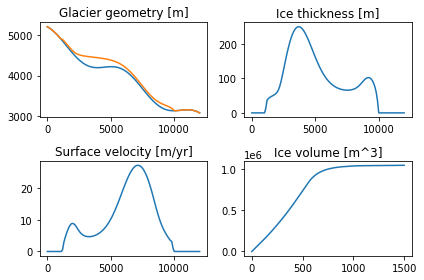

In [4]:
fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x,b_spinup, label = "Basal topography")
axs[0,0].plot(x,h_spinup[:,-1], label = "Ice Surface")
axs[0,0].set_title("Glacier geometry [m]")

axs[0,1].plot(x,H_spinup[:,-1], label = "Ice thickness")
axs[0,1].set_title("Ice thickness [m]")

axs[1,0].plot(x,vx_surface_spinup[:,-1], label = "Ice thickness")
axs[1,0].set_title("Surface velocity [m/yr]")

axs[1,1].plot(t,vol_spinup)
axs[1,1].set_title("Ice volume [m^3]")

fig.tight_layout()

## We now compare our result with the analytical formula given in Millian et.al Nature 2022.

Assume that the basal velocity is zero, therefore $\beta = 0$.

In [5]:
H_analytical = vx_surface_spinup[:,-1]*(n+1) / (2*A*(rho*g)**n*abs(alpha_sx_spinup[:,-1])**n)
H_analytical = H_analytical ** (1/(n+1))

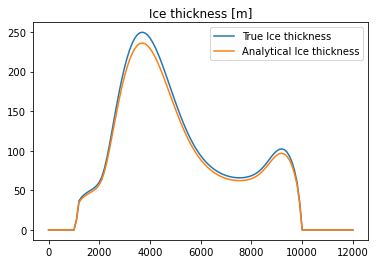

In [6]:
plt.plot(x,H_spinup[:,-1], label = "True Ice thickness")
plt.plot(x,H_analytical, label = "Analytical Ice thickness")
plt.title("Ice thickness [m]")
plt.legend()

## PINN for deterministic inversion of $b$ for steady state case

In [295]:
class PINN(nn.Module):
    
    def __init__ (self):

        super(PINN, self).__init__()

        self.fc1 = nn.Linear(1,20)
        self.fc2 = nn.Linear(20,20)
        self.fc3 = nn.Linear(20,20)
        self.fc4 = nn.Linear(20,20)
        self.fc5 = nn.Linear(20,20)
        self.fc6 = nn.Linear(20,20)
        self.fc7 = nn.Linear(20,20)
        self.fc8 = nn.Linear(20,20)
        self.fc9 = nn.Linear(20,20)
        self.fc10 = nn.Linear(20,20)
        self.fc11 = nn.Linear(20,20)
        self.fc12 = nn.Linear(20,1)

    def forward(self, x):
        
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = torch.relu(self.fc10(x))
        x = torch.relu(self.fc11(x))
        x = self.fc12(x)
        
        return x

PINN

__main__.PINN

In [296]:
### Collocation points
# N_c = 1000 # Number of collocation points
# x_c = torch.unsqueeze(torch.from_numpy(L*np.random.rand(N_c)), 1)
x_c = torch.unsqueeze(torch.from_numpy(x).float(), 1)

### Data
h_data = torch.unsqueeze(torch.from_numpy(h_spinup[:,-1]).float(), 1)
vx_data = torch.unsqueeze(torch.from_numpy(vx_surface_spinup[:,-1]).float(), 1)
x_data = torch.unsqueeze(torch.from_numpy(x).float(), 1)

### Parameters
C = C_spinup

C

2.4254200053759998e-05

In [378]:
pinn = PINN()
criterion = nn.MSELoss()

adam = torch.optim.Adam(pinn.parameters(), lr = 1e-3)
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=adam, step_size=1000, gamma=0.9)
b_true = torch.unsqueeze(torch.from_numpy(b_spinup), 1).float()
b = torch.zeros_like(x_c, requires_grad = True)
adam.add_param_group({'params': b, 'lr': 5.0e1})

In [379]:
statistics = []
for epochs in range(100000):

    x_c_clone = x_c.clone()
    x_c_clone.requires_grad = True
    x_d_clone = x_data.clone()
    x_d_clone.requires_grad = True
    
    h = pinn(x_c_clone/6000.)
    
    M = accum_rate_func(h)
    H = torch.sub(h, b)

    grad_h = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    h_x = grad_h[0]
    hess_h = torch.autograd.grad(torch.sum(h_x), x_c_clone, create_graph=True)
    h_xx = hess_h[0]

    flux = - C * torch.pow(torch.squeeze(H), n+2) * torch.pow(torch.abs(h_x), n-1) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), x_c_clone, create_graph=True)
    flux_x = - gradients_flux[0]
    pde_rhs = M + flux_x

    ### Separate data points
    #     h_d = pinn(x_d_clone)
    #     H_d = torch.sub(h_d, b)
    #     alpha = torch.autograd.grad(torch.sum(h_d), x_d_clone, create_graph=True)
    #     tau_d = - rho * g * H_d * alpha[0]
    #     phi = 0.0
    #     vx_d = 2*A/(n+2) * (tau_d)**n * H_d * (phi + 1)

    #     vx_d_loss = criterion(vx_d, vx_data)
    #     h_d_loss = criterion(pinn(x_d_clone), h_data)
    
    ### Data points same as collocation points
    alpha = torch.autograd.grad(torch.sum(h), x_c_clone, create_graph=True)
    tau = - rho * g * H * alpha[0]
    phi = 0.0
    vx = 2*A/(n+2) * (tau)**n * H * (phi + 1)
    vx_d_loss = 1000*criterion(vx, vx_data)
    
    adam.zero_grad()  
    h_d_loss = 1e7*criterion(h, h_data)
    b_loss = criterion(b, b_true)
    if (b_loss <= 9e3): break
    c_loss = 1000*(1+epochs/10000)*criterion(pde_rhs, torch.zeros_like(pde_rhs))
    l_loss = 5000*torch.linalg.norm(torch.sub(pinn(torch.ones(1)*0), b_true[0])) \
            + 5000*torch.linalg.norm(torch.sub(b[0], b_true[0]))
    r_loss = 5000*torch.linalg.norm(torch.sub(pinn(torch.ones(1)*L), b_true[-1])) \
            + 5000*torch.linalg.norm(torch.sub(b[-1], b_true[-1]))
    b_less_h_loss = 1e5*torch.sum(torch.nn.functional.relu(-H))
    loss =  h_d_loss + l_loss + r_loss + c_loss + b_less_h_loss #+ vx_d_loss
    loss.backward()       
    adam.step()
    #my_lr_scheduler.step()
    if ((epochs+1) % 250 == 0):
        #         statistics.append([epochs, 
        #                            loss.data.numpy(), 
        #                            l_loss.data.numpy(), 
        #                            r_loss.data.numpy(), 
        #                            c_loss.data.numpy(), 
        #                            h_d_loss.data.numpy(),
        #                            vx_d_loss.data.numpy()])
        print (f'epoch = {epochs+1}, data loss = {h_d_loss + vx_d_loss:.1e}, loss = {loss:.1e}, b_loss = {b_loss:.1e}, c_loss = {c_loss:.1e}, l_loss = {l_loss:.1e}, r_loss = {r_loss:.1e}, b_less_h_loss = {b_less_h_loss:.1e}')

epoch = 250, data loss = 1.4e+11, loss = 1.8e+11, b_loss = 7.4e+04, c_loss = 2.1e+10, l_loss = 2.6e+05, r_loss = 1.9e+10, b_less_h_loss = 1.2e+09
epoch = 500, data loss = 2.9e+10, loss = 4.7e+10, b_loss = 3.1e+04, c_loss = 1.8e+08, l_loss = 3.7e+05, r_loss = 1.7e+10, b_less_h_loss = 6.6e+08
epoch = 750, data loss = 1.5e+10, loss = 2.9e+10, b_loss = 2.7e+04, c_loss = 4.7e+07, l_loss = 3.8e+05, r_loss = 1.4e+10, b_less_h_loss = 5.5e+08
epoch = 1000, data loss = 1.0e+10, loss = 2.0e+10, b_loss = 2.5e+04, c_loss = 2.8e+07, l_loss = 2.8e+05, r_loss = 9.6e+09, b_less_h_loss = 4.9e+08
epoch = 1250, data loss = 8.0e+09, loss = 1.3e+10, b_loss = 2.3e+04, c_loss = 3.1e+07, l_loss = 2.4e+05, r_loss = 4.8e+09, b_less_h_loss = 4.2e+08
epoch = 1500, data loss = 6.6e+09, loss = 8.4e+09, b_loss = 2.2e+04, c_loss = 3.5e+07, l_loss = 1.9e+05, r_loss = 1.4e+09, b_less_h_loss = 3.8e+08
epoch = 1750, data loss = 5.5e+09, loss = 6.3e+09, b_loss = 2.1e+04, c_loss = 3.3e+07, l_loss = 1.4e+05, r_loss = 3.4e+08

In [380]:
h_d_loss

tensor(2.3746e+12, grad_fn=<MulBackward0>)

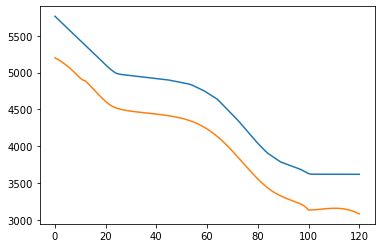

In [381]:
plt.plot(h.detach())
plt.plot(h_data)

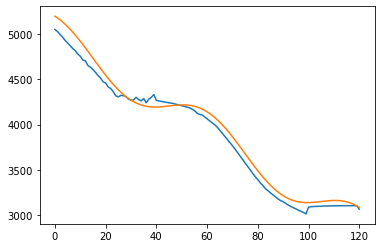

In [382]:
plt.plot(b.detach())
plt.plot(b_true)

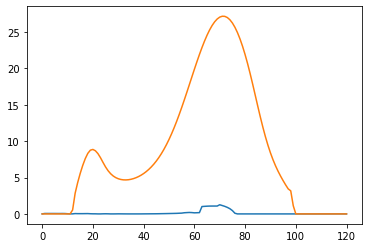

In [368]:
plt.plot(vx.detach())
plt.plot(vx_data)

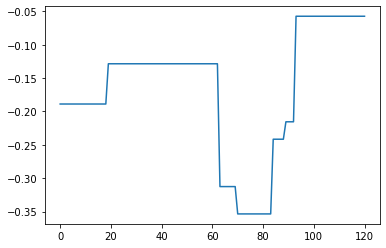

In [369]:
plt.plot(alpha[0].detach())

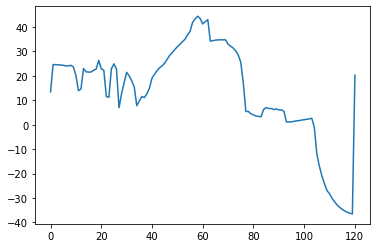

In [370]:
plt.plot(H.detach())